<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/finetune-like-you-pretrain/data-augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
tee requirements.txt << END
ftfy
jaxtyping
jupyter
matplotlib
pydantic
regex
torch
torchinfo
torchvision
tqdm
ultralytics
END

pip install -q -r requirements.txt
pip install -q git+https://github.com/openai/CLIP.git

In [2]:
import clip
import json
import os
import pickle
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import PIL
import itertools as it
import math

from datetime import datetime
from jaxtyping import Float, UInt, Int
from pydantic.dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchinfo import summary
from typing import Literal, Callable, Mapping, TypeVar
from tqdm import tqdm
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter

In [3]:
device: Literal['cpu', 'cuda'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
device

'cpu'

#### Utils

In [4]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [5]:
# args:
#  - predictionList: [Prediction]
#  - numPred: int :: if numPred==-1 (default) consider all the predictions in predictionList
def display_predictions(predictionList, numPred=-1):
  limit = 0
  for p in predictionList:
    if numPred!=-1 and limit >= numPred:
      return;
    limit += 1

    p_image = p.image

    if(not isinstance(p_image, torch.Tensor)):
      p_image = torchvision.transforms.PILToTensor()(p_image)

    p_description = p.description
    p_ground_truth_bbox = p.ground_truth_bbox
    p_output_bbox = p.output_bbox

    # TODO: concatenate
    p_image = draw_bounding_boxes(p_image, p_ground_truth_bbox.unsqueeze(0), colors="green", width=5)
    p_image = draw_bounding_boxes(p_image, p_output_bbox.unsqueeze(0), colors="red", width=5)

    tensor_to_pil = transforms.ToPILImage()
    image_pil = tensor_to_pil(p_image)
    display(image_pil)
    print(p_description)
    print("\n\n")

#### Dataset and type declaration

In [ ]:
%%shell
if ! [ -d dataset ]; then
  mkdir dataset &&
  gdown 1P8a1g76lDJ8cMIXjNDdboaRR5-HsVmUb &&
  tar -xf refcocog.tar.gz -C dataset &&
  rm refcocog.tar.gz
fi

In [7]:
root = os.path.join("dataset", "refcocog", "")
data_instances = os.path.join(root, "annotations", "instances.json")
data_refs = os.path.join(root, "annotations", "refs(umd).p")
data_images = os.path.join(root, "images", "")

In [8]:
I = TypeVar("I")
P = TypeVar("P")
B = TypeVar("B")
T = TypeVar("T")

Img = UInt[torch.Tensor, "C W H"]
BBox = UInt[torch.Tensor, "4"]
Split = Literal["train", "test", "val"]


@dataclass
class Info:
    description: str  # This is stable 1.0 version of the 2014 MS COCO dataset.
    url: str  # http://mscoco.org/
    version: str  # 1.0
    year: int  # 2014
    contributor: str  # Microsoft COCO group
    date_created: datetime  # 2015-01-27 09:11:52.357475


@dataclass
class Image:
    license: int  # each image has an associated licence id
    file_name: str  # file name of the image
    coco_url: str  # example http://mscoco.org/images/131074
    height: int
    width: int
    flickr_url: str  # example http://farm9.staticflickr.com/8308/7908210548_33e
    id: int  # id of the imag
    date_captured: datetime  # example '2013-11-21 01:03:06'


@dataclass
class License:
    url: str  # example http://creativecommons.org/licenses/by-nc-sa/2.0/
    id: int  # id of the licence
    name: str  # example 'Attribution-NonCommercial-ShareAlike License


@dataclass
class Annotation:
    # segmentation: list[list[float]]  # description of the mask; example [[44.17, 217.83, 36.21, 219.37, 33.64, 214.49, 31.08, 204.74, 36.47, 202.68, 44.17, 203.2]]
    area: float  # number of pixel of the described object
    iscrowd: Literal[
        1, 0
    ]  # Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people)
    image_id: int  # id of the target image
    bbox: tuple[
        float, float, float, float
    ]  # bounding box coordinates [xmin, ymin, width, height]
    category_id: int
    id: int  # annotation id


@dataclass
class Category:
    supercategory: str  # example 'vehicle'
    id: int  # category id
    name: str  # example 'airplane'


@dataclass
class Instances:
    info: Info
    images: list[Image]
    licenses: list[License]
    annotations: list[Annotation]
    categories: list[Category]


@dataclass
class Sentence:
    tokens: list[str]  # tokenized version of referring expression
    raw: str  # unprocessed referring expression
    sent: str  # referring expression with mild processing, lower case, spell correction, etc.
    sent_id: int  # unique referring expression id


@dataclass
class Ref:
    image_id: int  # unique image id
    split: Split
    sentences: list[Sentence]
    file_name: str  # file name of image relative to img_root
    category_id: int  # object category label
    ann_id: int  # id of object annotation in instance.json
    sent_ids: list[int]  # same ids as nested sentences[...][sent_id]
    ref_id: int  # unique id for refering expression

In [9]:
class Prediction:
  def __init__(self, image, description, ground_truth_bbox, output_bbox):
    self.image = image
    self.description = description
    self.ground_truth_bbox = ground_truth_bbox
    self.output_bbox = output_bbox

In [10]:
def fix_ref(x: Ref) -> Ref:
    x.file_name = fix_filename(x.file_name)
    return x


def fix_filename(x: str) -> str:
    """
    :param x: COCO_..._[image_id]_[annotation_id].jpg
    :return:  COCO_..._[image_id].jpg

    >>> fix_filename('COCO_..._[image_id]_0000000001.jpg')
    'COCO_..._[image_id].jpg'

    """
    return re.sub("_\d+\.jpg$", ".jpg", x)

In [11]:
with open(data_refs, "rb") as f:
    raw = pickle.load(f)

refs: list[Ref] = [fix_ref(Ref(**ref)) for ref in raw]

In [12]:
with open(data_instances, "r") as f:
    raw = json.load(f)

instances: Instances = Instances(**raw)

id2annotation: Mapping[int, Annotation] = {x.id: x for x in instances.annotations}

In [13]:
class CocoDataset(Dataset[tuple[PIL.Image, list[str], Float[torch.Tensor, "4"]]]):
    def __init__(
        self,
        split: Split,
        limit: int = -1,
    ):
        self.__init__
        self.items: list[tuple[str, list[str], Float[torch.Tensor, "4"]]] = [
            (i, [s.sent for s in ss], xywh)
            for ref in refs
            if ref.split == split
            for i in [os.path.join(data_images, ref.file_name)]
            for ss in [ref.sentences]
            for xywh in [torch.tensor(id2annotation[ref.ann_id].bbox, dtype=torch.float)]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(
        self, index: int
    ) -> tuple[PIL.Image, list[str], Float[torch.Tensor, "4"]]:
        i, ps, xywh = self.items[index]
        xyxy: Float[torch.Tensor, "4"] = torchvision.ops.box_convert(xywh, in_fmt="xywh", out_fmt="xyxy")
        with PIL.Image.open(i) as img:
            img.load()
            return img, ps, xyxy

In [14]:
class Coco4CLIPDataset(Dataset[tuple[list[PIL.Image], list[str]]]):
    def __init__(
        self,
        split: Split,
        limit: int = -1,
    ):
        self.__init__
        self.items: list[tuple[str, list[str], Float[torch.Tensor, "4"]]] = [
            (i, [s.sent for s in ss], xywh)
            for ref in refs
            if ref.split == split
            for i in [os.path.join(data_images, ref.file_name)]
            for ss in [ref.sentences]
            for xywh in [torch.tensor(id2annotation[ref.ann_id].bbox, dtype=torch.float)]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(self, index: int) -> tuple[list[PIL.Image], list[str]]:
        i, ps, xywh = self.items[index]
        xyxy: Float[torch.Tensor, "4"] = torchvision.ops.box_convert(xywh, in_fmt="xywh", out_fmt="xyxy")
        with PIL.Image.open(i) as img:
            img.load()
            return [img.crop(xyxy.tolist())], ps

In [15]:
def unzip(batch: list[tuple[T, ...]]) -> tuple[list[T], ...]:
    return tuple(zip(*batch))

In [16]:
batch_size: int = 3
limit: int = 5 * batch_size

In [17]:
dl: DataLoader[tuple[list[PIL.Image], list[list[str]], list[Float[torch.Tensor, "4"]]]] = DataLoader(
    dataset=CocoDataset(split="test", limit=limit),
    batch_size=batch_size,
    collate_fn=unzip,
)

In [19]:
dl4clip: DataLoader[tuple[list[PIL.Image], list[str]]] = DataLoader(
    dataset=Coco4CLIPDataset(split="test", limit=limit),
    batch_size=batch_size,
    collate_fn=unzip,
    generator=torch.Generator(device=device), # add for GPU
    shuffle=True,
)

In [ ]:
imgs: tuple[PIL.Image, ...]
promptss: tuple[list[str], ...]
true_xyxy: tuple[Float[torch.Tensor, "4"], ...]

for imgs, promptss, true_xyxy in dl:
    print(imgs)
    print(promptss)
    print(true_xyxy)
    print("-" * 50)

In [ ]:
cropss: tuple[list[PIL.Image], ...]
promptss: tuple[list[str], ...]

for cropss, promptss in dl4clip:
    print(cropss)
    print(promptss)
    print("-" * 50)

# Data augmentation functions

In [22]:
import random

## Image augmentation

In [23]:
class ImageAugmentation(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.transforms = [
      transforms.ColorJitter(brightness=.5, hue=.3),                # randomly changes the brightness, saturation, and other properties of an image
      transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # performs gaussian blur transform on an image
      transforms.RandomInvert(),                                    # randomly inverts the colors of the given image
      transforms.RandomPosterize(bits=2),                           # randomly posterizes the image by reducing the number of bits of each color channel
      transforms.RandomSolarize(threshold=192.0),                   # randomly solarizes the image by inverting all pixel values above the threshold
      transforms.RandomAdjustSharpness(sharpness_factor=2),         # randomly adjusts the sharpness of the given image
      transforms.RandomAutocontrast(),                              # randomly applies autocontrast to the given image
      transforms.RandomEqualize(),                                  # randomly equalizes the histogram of the given image
      transforms.Grayscale(num_output_channels=3)                   # converts an image to grayscale
    ]

  # imgs: list of original images
  # final_size: total desired number of images
  def __call__(self, imgs, final_size):
    # number of images already satisfied
    if len(imgs) >= final_size:
      return imgs

    random_transforms = random.sample(self.transforms, final_size-len(imgs))  # sample the required number of transformations to achieve the desired final set size
    original_images = random.choices(imgs, k=len(random_transforms))          # select a random number of original images on which we apply the random transformation

    for transformation, original_image in zip(random_transforms, original_images):
      imgs.append(transformation(original_image))

    return imgs

## Text augmentation

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install textaugment

In [ ]:
# EDA
# paper: https://aclanthology.org/D19-1670.pdf
# paper: https://arxiv.org/abs/1907.03752
# code reference: https://github.com/dsfsi/textaugment
from textaugment import EDA
import nltk # NLTK is a leading platform for building Python programs to work with human language data
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# PEGASUS fine-tuned for paraphrasing
# paper: https://arxiv.org/abs/1912.08777
# code reference: https://huggingface.co/tuner007/pegasus_paraphrase
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
pegasus_model_name = 'tuner007/pegasus_paraphrase'
pegasus_torch_device = device
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to(pegasus_torch_device)

In [27]:
def pegasus_get_response(input_text,num_return_sequences=1,num_beams=10):
  batch = pegasus_tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(pegasus_torch_device)
  translated = pegasus_model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = pegasus_tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
# A large BART seq2seq (text2text generation) model fine-tuned on 3 paraphrase datasets.
# paper: https://arxiv.org/abs/1910.13461
# code reference: https://huggingface.co/eugenesiow/bart-paraphrase
from transformers import BartForConditionalGeneration, BartTokenizer
bart_model = BartForConditionalGeneration.from_pretrained('eugenesiow/bart-paraphrase')
bart_torch_device = device
bart_model = bart_model.to(bart_torch_device)
bart_tokenizer = BartTokenizer.from_pretrained('eugenesiow/bart-paraphrase')

In [38]:
class TextAugmentation(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.eda_transformation = EDA(random_state=1)  # EDA initialization

    self.transforms = [
        self.eda_synonym_replacement,
        self.template_insertion("A photo of {}"),
        self.template_insertion("A picture of {}"),
        self.template_insertion("An image of {}"),
        self.template_insertion("This is {}"),
        self.template_insertion("We can see {}"),
        self.pegasus_augmentation,
        self.bert_augmentation
    ]

  # randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random
  def eda_synonym_replacement(self, txt):
    return self.eda_transformation.synonym_replacement(txt)

  # add a template as suggested by the CLIP paper. Examples: A photo of {}, We can see {}, ...
  def template_insertion(self, template):
    return template.format

  # pegasus paraphrasing
  def pegasus_augmentation(self, txt):
    return pegasus_get_response(txt)[0]

  # bert paraphrasing
  def bert_augmentation(self, txt):
    batch = bart_tokenizer(txt, return_tensors='pt')
    generated_ids = bart_model.generate(batch['input_ids'])
    generated_sentence = bart_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return generated_sentence[0]

  # txts: list of original prompts
  # final_size: total desired number of prompts
  def __call__(self, txts, final_size):
    # number of txts already satisfied
    if len(txts) >= final_size:
      return txts

    random_transforms = random.sample(self.transforms, final_size-len(txts))  # sample the required number of transformations to achieve the desired final set size
    original_texts = random.choices(txts, k=len(random_transforms))           # select a random number of original texts on which we apply the random transformation

    for transformation, original_text in zip(random_transforms, original_texts):
      txts.append(transformation(original_text))

    return txts

# Fine tune like you pretrain
In the following we try to fine tune CLIP image and text encoders using contrastive learning as proposed by the original paper.

### model definition

In [44]:
class FLYP_CLIP(nn.Module):
  def __init__(self, device=device):  #TODO: aggiungere device=device anche nelle architetture dello standard fine tuning

    super().__init__()

    model, preprocess = clip.load('RN50')

    # freeze all pretrained layers by setting requires_grad=False
    for param in model.parameters():
      param.requires_grad = False

    self.clip_visual_encoder = model.encode_image
    self.clip_text_encoder = model.encode_text
    self.clip_visual_preprocess = preprocess
    self.clip_text_preprocess = clip.tokenize

    self.visual_encoder_linearHead = nn.Linear(1024, 1024)
    self.text_encoder_linearHead = nn.Linear(1024, 1024)

    # the temperature parameter is added as suggested by the original paper in order to prevent training instability
    self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

  # preprocess input prompts as required by the visual encoder
  def visual_preprocess(self, _imgs):
    prep_images = torch.stack([
        self.clip_visual_preprocess(i)
        for i in _imgs
    ]).to(device)

    return prep_images

  # preprocess text prompts as required by the text encoder
  def text_preprocess(self, _txts):
    prep_texts = self.clip_text_preprocess(_txts)

    return prep_texts

  # visual encoder
  def visual_encoder(self, image):
    with torch.no_grad():
      clipFeatures = self.clip_visual_encoder(image).float()  # add for GPU

    x = F.relu(clipFeatures)
    x = self.visual_encoder_linearHead(x)

    return x

  # text encoder
  def text_encoder(self, text):
    with torch.no_grad():
      clipFeatures = self.clip_text_encoder(text).float()  # add for GPU

    x = F.relu(clipFeatures)
    x = self.text_encoder_linearHead(x)

    return x

  def forward(self, image, text):
    with torch.no_grad():
      image_pre = self.visual_preprocess(image)
      text_pre = self.text_preprocess(text)

    image_features = self.visual_encoder(image_pre)
    text_features = self.text_encoder(text_pre)

    return image_features, text_features, self.logit_scale.exp()

In [45]:
def get_optimizer(model, _lr, _wd, _momentum):
  optimizer = torch.optim.SGD(  params = model.parameters(),
                                lr = _lr,
                                weight_decay = _wd,
                                momentum = _momentum)
  return optimizer

In [46]:
class ClipLoss(nn.Module):

    def __init__(self):
        super().__init__()

    def get_ground_truth(self, num_logits):
        labels = torch.arange(num_logits)
        return labels

    def get_logits(self, image_features, text_features, logit_scale):
        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text = logit_scale * text_features @ image_features.T

        return logits_per_image, logits_per_text

    def forward(self, image_features, text_features, logit_scale):

        # compute logits per image and logits per text
        logits_per_image, logits_per_text = self.get_logits(image_features, text_features, logit_scale)

        # get ground truth labels for the computation of the cross entropy loss
        labels = self.get_ground_truth(logits_per_image.shape[0])

        total_loss = (
            F.cross_entropy(logits_per_image, labels) +
            F.cross_entropy(logits_per_text, labels)
        ) / 2

        return total_loss

### training

In [47]:
def training_step(
    model: torch.nn.Module,                   # neural network to be trained
    data_loader: torch.utils.data.DataLoader, # data loader to be iterated
    loss_fn: torch.nn.Module,                 # loss function
    optimizer: torch.optim.Optimizer,         # optimizer
    device: torch.device = device             #target device
):
  train_loss = 0.0

  model.to(device)
  model.train()

  text_augment = TextAugmentation()
  image_augment = ImageAugmentation()
  num_synonyms = 3

  for batch_idx, (cropss, promptss) in tqdm(enumerate(data_loader)):

    # apply data agumentation
    for crops, prompts in zip(cropss, promptss):
      crops = image_augment(crops, num_synonyms)
      prompts = text_augment(prompts, num_synonyms)

    loss = 0.0
    for syn_number in range(num_synonyms):  # iterate through the synonyms
      # instantiate synonym instance
      model_input_crops = [c[syn_number] for c in cropss]
      model_input_prompts = [p[syn_number] for p in promptss]

      # send data to target device
      ####cropss = cropss.to(device)
      ####promptss = promptss.to(device)

      # forward computation
      model_out = model(model_input_crops, model_input_prompts)
      image_features = model_out[0]
      text_features = model_out[1]
      logit_scale = model_out[2]

      # calculate loss
      loss = loss + loss_fn(image_features, text_features, logit_scale)

    # compute average loss across multiple synonyms
    loss = loss / num_synonyms
    train_loss += loss

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # Note: we clamp to 4.6052 = ln(100), as in the original paper.
    with torch.no_grad():
        model.logit_scale.clamp_(0, math.log(100))

  # Calculate loss per epoch and print out what's happening
  train_loss /= len(data_loader)
  print(f"\nTrain loss: {train_loss:.5f}\n")
  return train_loss

### test step

In [48]:
def test_step(
    model: torch.nn.Module,                   # neural network to be evaluated
    data_loader: torch.utils.data.DataLoader, # data loader to be iterated
    loss_fn: torch.nn.Module,                 # loss function
    device: torch.device = device             #target device
):
  test_loss = 0.0

  model.to(device)
  model.eval()

  with torch.inference_mode():
    #for batch_idx, cropss, promptss in tqdm(enumerate(data_loader)):
    for batch_idx, (cropss, promptss) in tqdm(enumerate(data_loader)):

      # for this implementation we consider only one prompt for each crop
      model_input_crops = [c[0] for c in cropss]
      model_input_prompts = [p[0] for p in promptss]

      # send data to target device
      ####cropss = cropss.to(device)
      ####promptss = promptss.to(device)

      # forward computation
      model_out = model(model_input_crops, model_input_prompts)
      image_features = model_out[0]
      text_features = model_out[1]
      logit_scale = model_out[2]

      # calculate loss
      loss = loss_fn(image_features, text_features, logit_scale)
      test_loss += loss

    test_loss /= len(data_loader)
    print(f"\nTest loss: {test_loss:.5f}\n")
    return test_loss

### main loop

In [49]:
# instantiate the network and move it to the chosen device
net = FLYP_CLIP().to(device)

In [50]:
# tensorboard logging utilities
def log_values(writer, step, loss, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)

In [51]:
# setting a manual seed allow us to provide reprudicible results in this notebook
torch.manual_seed(42)

# create a logger for the experiment
writer = SummaryWriter(log_dir="runs/exp1")

BATCH_SIZE = 3
LIMIT = 5 * BATCH_SIZE
NUM_WORKERS = 1

# get dataset instance
train_dataset = Coco4CLIPDataset(split="train", limit=LIMIT)
test_dataset = Coco4CLIPDataset(split="test", limit=LIMIT)
val_dataset = Coco4CLIPDataset(split="val", limit=LIMIT)
print(f"LEN_TRAIN_DATASET: {len(train_dataset)}, LEN_TEST_DATASET: {len(test_dataset)}, LEN_VALIDATION_DATASET: {len(val_dataset)}")

# get dataloaders
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_loader: DataLoader[tuple[list[PIL.Image], list[str]]] = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=unzip,
    generator=torch.Generator(device=device), # add for GPU
    shuffle=True,
)
test_loader: DataLoader[tuple[list[PIL.Image], list[str]]] = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=unzip,
    shuffle=False,
)
val_loader: DataLoader[tuple[list[PIL.Image], list[str]]] = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=unzip,
    shuffle=False,
)
print(f"LEN_TRAIN_DATALOADER: {len(train_loader)}, LEN_TEST_DATALOADER: {len(val_loader)}, LEN_VALIDATION_DATALOADER: {len(test_loader)}")

# instantiate the optimizer
learning_rate = 0.01
weight_decay = 0.000001
momentum = 0.9
optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

# define the cost function
cost_function = ClipLoss().to(device)

print('Before training:')
train_loss = test_step(model = net,
        data_loader = train_loader,
        loss_fn = cost_function)
val_loss = test_step(model = net,
        data_loader = val_loader,
        loss_fn = cost_function)
test_loss = test_step(model = net,
        data_loader = test_loader,
        loss_fn = cost_function)

# log to TensorBoard
log_values(writer, -1, train_loss, "train")
log_values(writer, -1, val_loss, "validation")
log_values(writer, -1, test_loss, "test")

print('\tTraining loss {:.5f}'.format(train_loss))
print('\tValidation loss {:.5f}'.format(val_loss))
print('\tTest loss {:.5f}'.format(test_loss))
print('-----------------------------------------------------')

# measure time
train_time_start = timer()

EPOCHS = 3
for epoch in tqdm(range(EPOCHS)):
    train_loss = training_step(
        model = net,
        data_loader = train_loader,
        loss_fn = cost_function,
        optimizer = optimizer
    )

    val_loss = test_step(
        model = net,
        data_loader = val_loader,
        loss_fn = cost_function
    )

    # logs to TensorBoard
    log_values(writer, epoch, train_loss, "train")
    log_values(writer, epoch, val_loss, "validation")

    print('Epoch: {:d}'.format(epoch+1))
    print('\tTraining loss {:.5f}'.format(train_loss))
    print('\tValidation loss {:.5f}'.format(val_loss))
    print('-----------------------------------------------------')

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)
# compute final evaluation results
print('After training:')
train_loss = test_step(model = net,
        data_loader = train_loader,
        loss_fn = cost_function)
val_loss = test_step(model = net,
        data_loader = val_loader,
        loss_fn = cost_function)
test_loss = test_step(model = net,
        data_loader = test_loader,
        loss_fn = cost_function)

# log to TensorBoard
log_values(writer, EPOCHS, train_loss, "train")
log_values(writer, EPOCHS, val_loss, "validation")
log_values(writer, EPOCHS, test_loss, "test")

print('\tTraining loss {:.5f}'.format(train_loss))
print('\tValidation loss {:.5f}'.format(val_loss))
print('\tTest loss {:.5f}'.format(test_loss))
print('-----------------------------------------------------')

# closes the logger
writer.close()

LEN_TRAIN_DATASET: 15, LEN_TEST_DATASET: 15, LEN_VALIDATION_DATASET: 15
Creating DataLoader's with batch size 3 and 1 workers.
LEN_TRAIN_DATALOADER: 5, LEN_TEST_DATALOADER: 5, LEN_VALIDATION_DATALOADER: 5
Before training:


5it [00:05,  1.07s/it]



Test loss: 1.27907



5it [00:06,  1.37s/it]



Test loss: 1.47596



5it [00:05,  1.18s/it]



Test loss: 1.17082

	Training loss 1.27907
	Validation loss 1.47596
	Test loss 1.17082
-----------------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:15, 15.26s/it]
2it [00:28, 14.30s/it]
3it [00:32,  9.21s/it]
4it [00:50, 12.79s/it]
5it [00:59, 11.83s/it]



Train loss: 1.23344




0it [00:00, ?it/s]
1it [00:01,  1.02s/it]
2it [00:02,  1.05s/it]
3it [00:03,  1.06s/it]
4it [00:04,  1.07s/it]
5it [00:05,  1.08s/it]
 33%|███▎      | 1/3 [01:04<02:09, 64.55s/it]


Test loss: 1.77820

Epoch: 1
	Training loss 1.23344
	Validation loss 1.77820
-----------------------------------------------------



0it [00:00, ?it/s]
1it [00:03,  3.26s/it]
2it [00:08,  4.27s/it]
3it [00:11,  3.99s/it]
4it [00:14,  3.64s/it]
5it [00:18,  3.64s/it]



Train loss: 1.11659




0it [00:00, ?it/s]
1it [00:01,  1.10s/it]
2it [00:02,  1.50s/it]
3it [00:04,  1.60s/it]
4it [00:06,  1.60s/it]
5it [00:07,  1.51s/it]
 67%|██████▋   | 2/3 [01:30<00:41, 41.74s/it]


Test loss: 2.17778

Epoch: 2
	Training loss 1.11659
	Validation loss 2.17778
-----------------------------------------------------



0it [00:00, ?it/s]
1it [00:03,  3.26s/it]
2it [00:06,  3.21s/it]
3it [00:09,  3.31s/it]
4it [00:14,  3.98s/it]
5it [00:19,  3.98s/it]



Train loss: 1.37394




0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.09s/it]
3it [00:03,  1.08s/it]
4it [00:04,  1.08s/it]
5it [00:05,  1.15s/it]
100%|██████████| 3/3 [01:55<00:00, 38.67s/it]



Test loss: 1.52905

Epoch: 3
	Training loss 1.37394
	Validation loss 1.52905
-----------------------------------------------------
Train time on cpu: 116.004 seconds
After training:


5it [00:07,  1.41s/it]



Test loss: 0.14803



5it [00:05,  1.06s/it]



Test loss: 1.52905



5it [00:07,  1.42s/it]


Test loss: 1.40939

	Training loss 0.14803
	Validation loss 1.52905
	Test loss 1.40939
-----------------------------------------------------


# Test the model on our down stream task
In the following of the notebook we test the performance of the trained model on our objective task.

## Yolov5

In [52]:
class Yolo_v5(torch.nn.Module):
  def __init__(self, device=device):
    super().__init__()

    # load yolo model
    self.yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    self.yolo_model.to(device=device).eval()

  def forward(self, img):

    # yolo bboxes
    predictions = self.yolo_model(img)

    # xmin,      ymin,      xmax,      ymax,      confidence, class
    # 274.06390, 231.20389, 392.66345, 372.59018, 0.93251,    23.00000
    bboxes: list[Float[torch.Tensor, 'X 6']] = predictions.xyxy # bboxes[i] contains the bboxes highlighted by yolo in image i

    for image_idx, bbox_img in enumerate(bboxes):
      # if empty, put a bbox equal to image size
      if len(bbox_img) == 0:
          bboxes[image_idx] = torch.tensor([[0, 0, img[image_idx].size[0], img[image_idx].size[1], 0, 0]], dtype=torch.float)

    return bboxes

In [ ]:
# instantiate the region proposal algorithm
yolo = Yolo_v5().to(device)

## Evaluation code

In [54]:
def get_accuracy_function():
  def iou_accuracy(bbox_prediction, bbox_groundtruth):

    # compute intersection over union between ground truth bboxes and predicted bboxes
    iou_accuracy_matrix = torchvision.ops.box_iou(bbox_prediction[:, :4], bbox_groundtruth)

    # extract the diagonal elements
    iou_accuracy_matrix_diagonal = torch.diag(iou_accuracy_matrix)

    # compute the mean of the intersection over union
    mean_iou = iou_accuracy_matrix_diagonal.mean()

    # compute the iou accuracy
    iou_accuracy_output = mean_iou.item()

    return iou_accuracy_output
  return iou_accuracy

In [55]:
# input:
#   -> retrived_bboxes : bounding boxes proposed by the region proposal model
#   -> bbox_groundtruth : ground truth bounding box provided by the training sample
# output:
#   -> [3, 5] in this case for the first element in the batch the best bbox is the fourth, while for the second element in the batch the best bbox is the sixth. The best bbox is the one characterized by the largest IoU with the ground truth bbox
def best_bbox_one_hot_encoding(retrived_bboxes, bbox_groundtruth):
  batch_bbox_one_hot_encoding = []
  for batch_item_retrived_bboxes, batch_item_bbox_groundtruth in zip(retrived_bboxes, bbox_groundtruth):
    iou_matrix = torchvision.ops.box_iou(batch_item_retrived_bboxes[:,:4], batch_item_bbox_groundtruth.unsqueeze(0))
    batch_bbox_one_hot_encoding.append(torch.argmax(iou_matrix, dim=0))

  batch_bbox_one_hot_encoding = torch.cat(batch_bbox_one_hot_encoding, dim=0)

  return batch_bbox_one_hot_encoding

In [56]:
def evaluation( data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                region_proposal_model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
  test_loss, iou_test_acc = 0, 0
  model.to(device)
  region_proposal_model.to(device)

  with torch.inference_mode():
    for batch_idx, (imgs, promptss, true_xyxy) in tqdm(enumerate(data_loader)):
      # send data to target device
      # todo: send data to target device

      # forward pass
      # i. region proposal
      bboxes = region_proposal_model(imgs)

      # ii. get best bounding box with respect to the ground truth
      bbox_groundtruth = best_bbox_one_hot_encoding(bboxes, true_xyxy)

      # from yolo bboxes to cropped images
      crops = []
      for batch_image, batch_image_bboxes in zip(imgs, bboxes):
        list_bboxes_image: list[Image] = [
            batch_image.crop((xmin, ymin, xmax, ymax))
            for bbox in batch_image_bboxes
            for [xmin, ymin, xmax, ymax, _, _] in [bbox.tolist()]
        ]

        crops.append(list_bboxes_image)

      # forward pass
      cropss_z = []
      promptss_z = []
      for c, p in zip(crops, promptss):
        model_output = model(c, p)
        model_output_image_features = model_output[0]
        model_output_text_features = model_output[1]
        _ = model_output[2]

        cropss_z.append(model_output_image_features)
        promptss_z.append(model_output_text_features)


      # cosine similarity evaluation
      #   cropss_z :: list of BATCH_SIZE tensors: [tensor([bbox_img_1, 1024]), tensor([bbox_img_2, 1024]), ..., tensor([bbox_img_BATCH_SIZE, 1024])]
      #   promptss_z :: list of BATCH_SIZE tensors: [tensor([prompts_img_1, 1024]), tensor([prompts_img_2, 1024]), ..., tensor([prompts_img_BATCH_SIZE, 1024])]
      bbox_index_pred = []  # for each batch sample this list contains the index of the predicted bbox at the end of the iteration
      loss = 0.0
      for c_z, p_z, y in zip(cropss_z, promptss_z, bbox_groundtruth):
        crop_logits = []  # for each crop we set the average cosine similarity with the prompts
        for vector_c_z in c_z:
          vector_c_z_cos_similarities = []
          for vector_p_z in p_z:
            cosine_similarity = torch.nn.CosineSimilarity()(vector_c_z.unsqueeze(0), vector_p_z.unsqueeze(0)).item()
            vector_c_z_cos_similarities.append(cosine_similarity)

          mean_cosine_similarity = sum(vector_c_z_cos_similarities) / len(vector_c_z_cos_similarities)

          crop_logits.append(mean_cosine_similarity)

        # calculate loss
        loss = loss + loss_fn(torch.tensor(crop_logits).to(device), y.to(device))

        # get index of the predicted bounding box in order to compute IoU accuracy
        bbox_index_pred.append(crop_logits.index(max(crop_logits)))

      loss = loss / len(bbox_groundtruth)  # avg loss
      test_loss += loss

      # get predicted bounding box for each example in the batch
      bbox_pred = [batch_example_bboxes[idx] for batch_example_bboxes, idx in zip(bboxes, bbox_index_pred)]

      prediction_obj = Prediction(imgs[0], promptss[0], true_xyxy[0], bbox_pred[0][:4])
      display_predictions([prediction_obj])

      # calculate intersection over union train accuracy
      acc = accuracy_fn(torch.stack(bbox_pred, dim=0), torch.stack(list(true_xyxy), dim=0))
      iou_test_acc += acc

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    iou_test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | IoU test accuracy: {iou_test_acc:.5f}\n")
    return test_loss, iou_test_acc

In [57]:
# tensorboard logging utilities
def log_values_evaluation(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

LEN_TRAIN_DATASET: 15, LEN_TEST_DATASET: 15, LEN_VALIDATION_DATASET: 15
Creating DataLoader's with batch size 3 and 1 workers.
LEN_TRAIN_DATALOADER: 5, LEN_TEST_DATALOADER: 5, LEN_VALIDATION_DATALOADER: 5
Evalutation on the downstream task:


0it [00:00, ?it/s]

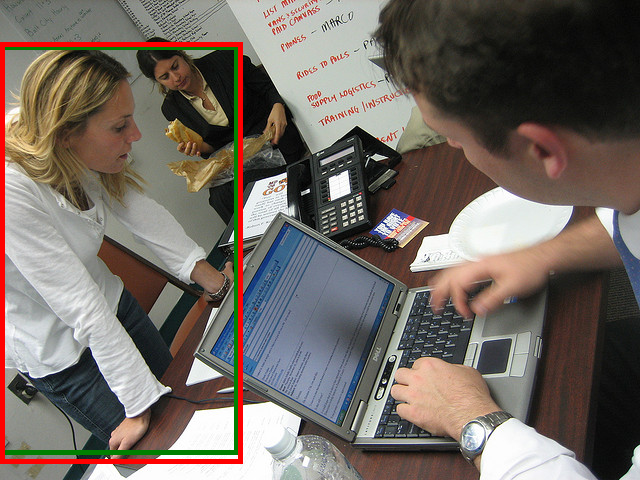

1it [00:11, 11.61s/it]

['two woman one in black eatting and the other has a white shirt at the desk', 'woman in white shirt looking down at laptop computer']





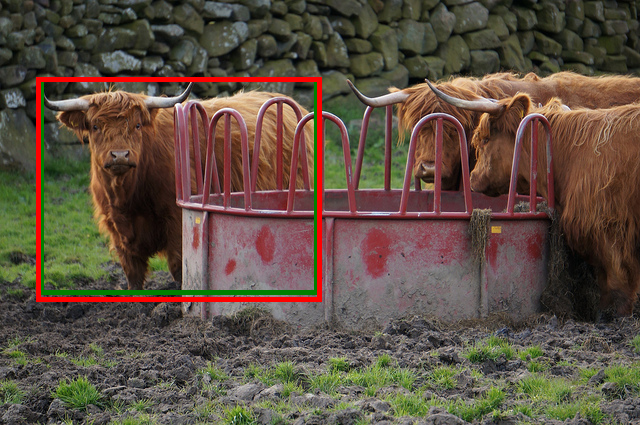

2it [00:16,  7.74s/it]

['a long - horn , long - haired brown cow looking at the camera', 'a brown bull in front of feeding tub']





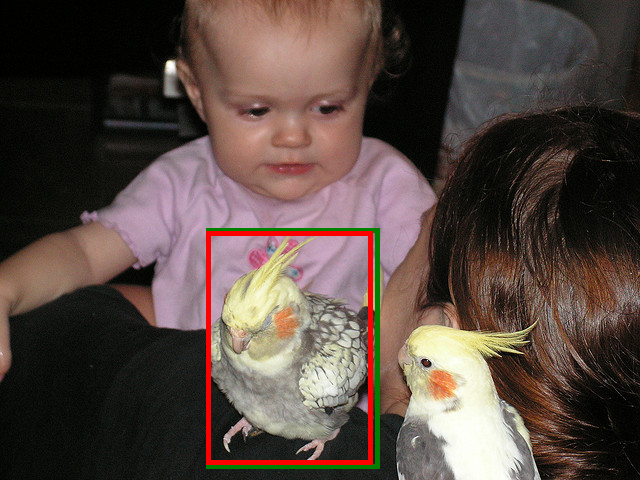

3it [00:29, 10.26s/it]

['a bird that is close to the baby in a pink shirt', 'a bird standing on the shoulder of a person with its tail touching her face']





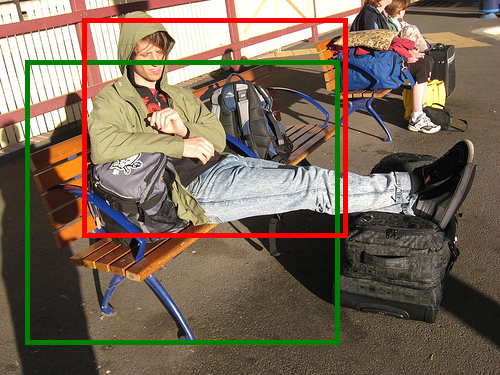

4it [00:42, 11.08s/it]

['park bench the man is sitting on']





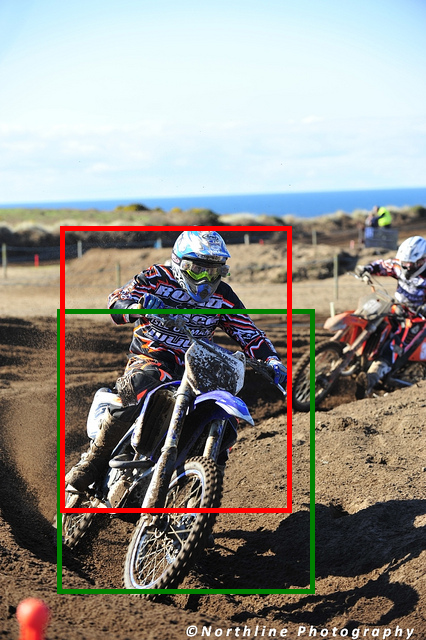

5it [00:47,  9.42s/it]


['a blue bike which come first', 'the blue dirt bike']



Test loss: 1.74343 | IoU test accuracy: 0.63127



0it [00:00, ?it/s]

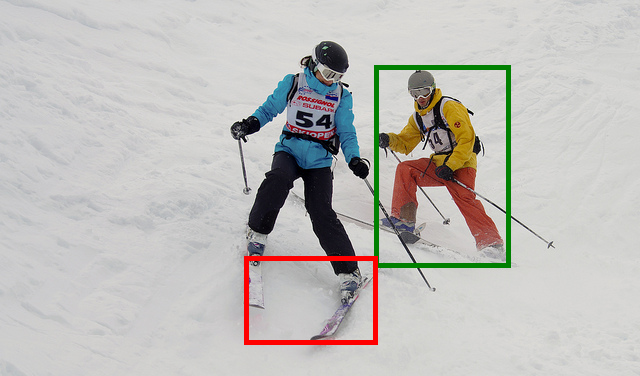

1it [00:08,  8.51s/it]

['the man in yellow coat', 'skiier in red pants']





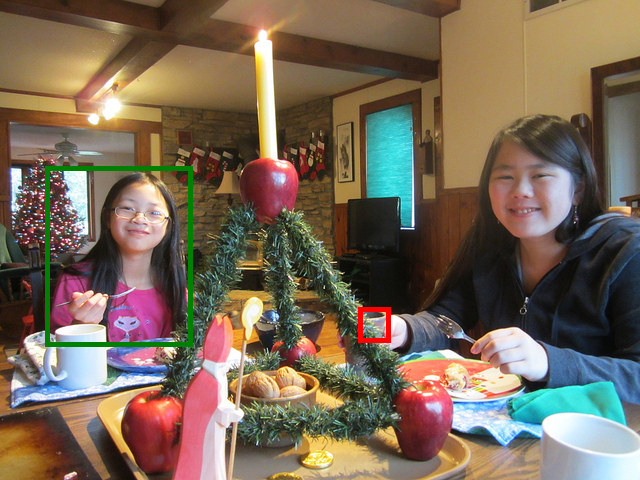

2it [00:16,  8.19s/it]

['a girl wearing glasses and a pink shirt', 'an asian girl with a pink shirt eating at the table']





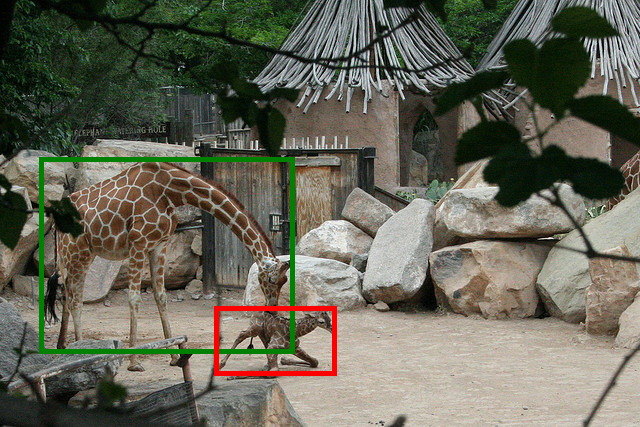

3it [00:22,  7.29s/it]

['the adult giraffe', 'a mother giraffe lickicking her baby']





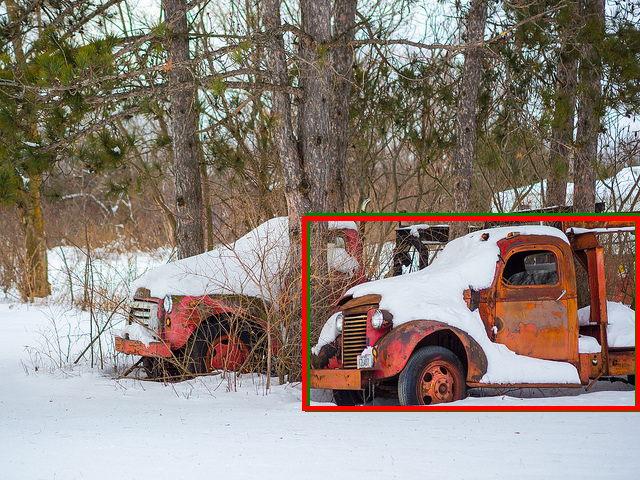

4it [00:34,  8.95s/it]

['the truck covered in the snow furthest to the right', 'an old truck covered in snow except for the grill and door']





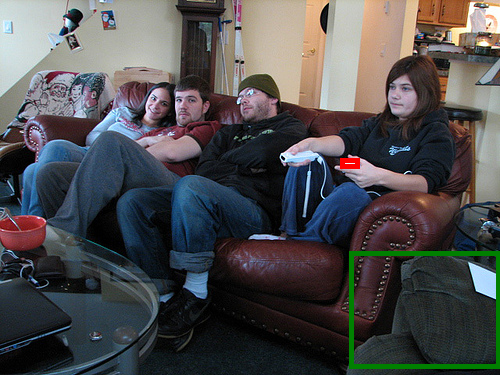

5it [00:42,  8.50s/it]


['lower right of couch and black arm of chair', 'a gray couch']



Test loss: 1.63373 | IoU test accuracy: 0.11430



0it [00:00, ?it/s]

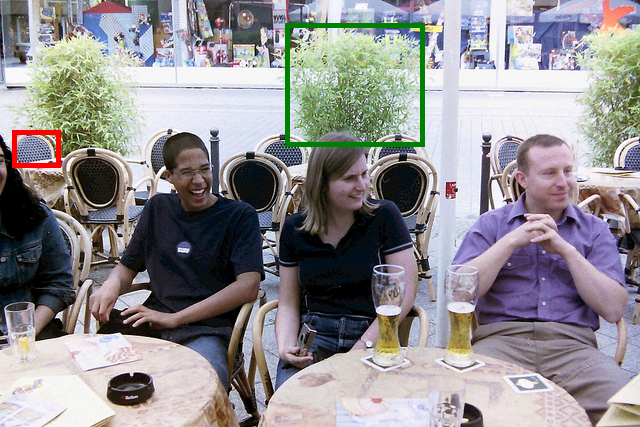

1it [00:16, 16.39s/it]

['a bush of plant behind middle woman', "green plant behind a table visible behind a lady ' s head"]





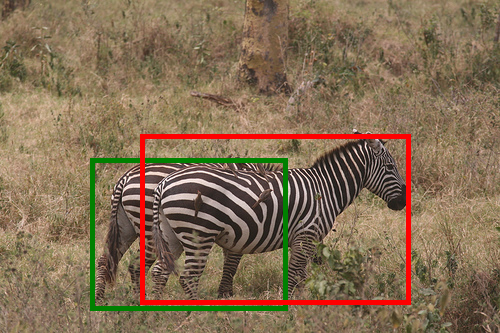

2it [00:21,  9.73s/it]

['the zebra on the left in the right hand picture']





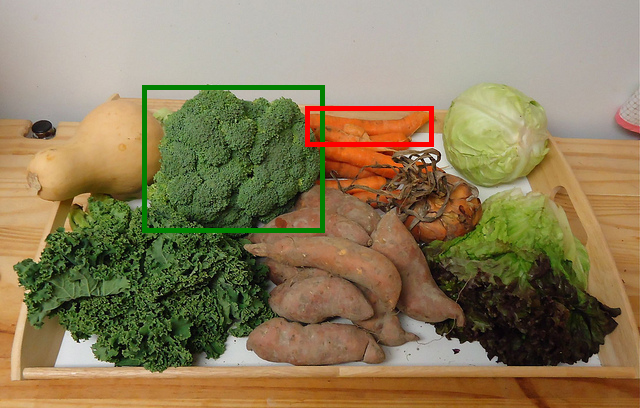

3it [00:29,  8.73s/it]

['green color vegetable in between potato and carrot', 'bundle of broccoli']





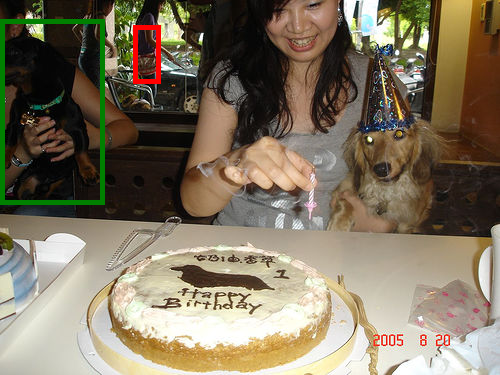

4it [00:34,  7.62s/it]

['the black dog with the blue collar . on the left', 'the black dog with the green collar']





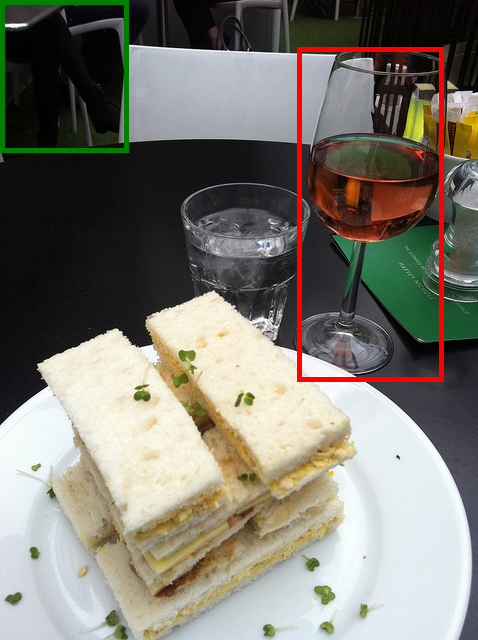

5it [00:45,  9.01s/it]

['a dark table in the far left hand background']



Test loss: 1.76092 | IoU test accuracy: 0.12842

	Training loss 1.74343, Training accuracy 0.63127
	Validation loss 1.76092, Validation accuracy 0.12842
	Test loss 1.63373, Test accuracy 0.11430
-----------------------------------------------------


In [58]:
# setting a manual seed allow us to provide reprudicible results in this notebook
torch.manual_seed(42)

# create a logger for the experiment
writer = SummaryWriter(log_dir="runs/exp1")

BATCH_SIZE = 3
LIMIT = 5 * BATCH_SIZE

# get dataset instance
train_dataset = CocoDataset(split="train", limit=LIMIT)
test_dataset = CocoDataset(split="test", limit=LIMIT)
val_dataset = CocoDataset(split="val", limit=LIMIT)
print(f"LEN_TRAIN_DATASET: {len(train_dataset)}, LEN_TEST_DATASET: {len(test_dataset)}, LEN_VALIDATION_DATASET: {len(val_dataset)}")

# get dataloaders
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
train_loader: DataLoader[tuple[list[PIL.Image], list[list[str]], list[Float[torch.Tensor, "4"]]]] = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=unzip,
)
test_loader: DataLoader[tuple[list[PIL.Image], list[list[str]], list[Float[torch.Tensor, "4"]]]] = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=unzip,
)
val_loader: DataLoader[tuple[list[PIL.Image], list[list[str]], list[Float[torch.Tensor, "4"]]]] = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=unzip,
)
print(f"LEN_TRAIN_DATALOADER: {len(train_loader)}, LEN_TEST_DATALOADER: {len(val_loader)}, LEN_VALIDATION_DATALOADER: {len(test_loader)}")

# define the cost function
loss_function = torch.nn.CrossEntropyLoss()

# define the accuracy function
accuracy_fn = get_accuracy_function()

print('Evalutation on the downstream task:')
train_loss, train_accuracy = evaluation(data_loader = train_loader, model = net, region_proposal_model = yolo, loss_fn = loss_function, accuracy_fn = accuracy_fn)
test_loss, test_accuracy = evaluation(data_loader = test_loader, model = net, region_proposal_model = yolo, loss_fn = loss_function, accuracy_fn = accuracy_fn)
val_loss, val_accuracy = evaluation(data_loader = val_loader, model = net, region_proposal_model = yolo, loss_fn = loss_function, accuracy_fn = accuracy_fn)

# log to TensorBoard
log_values_evaluation(writer, -1, train_loss, train_accuracy, "train")
log_values_evaluation(writer, -1, val_loss, val_accuracy, "validation")
log_values_evaluation(writer, -1, test_loss, test_accuracy, "test")

print('\tTraining loss {:.5f}, Training accuracy {:.5f}'.format(train_loss, train_accuracy))
print('\tValidation loss {:.5f}, Validation accuracy {:.5f}'.format(val_loss, val_accuracy))
print('\tTest loss {:.5f}, Test accuracy {:.5f}'.format(test_loss, test_accuracy))
print('-----------------------------------------------------')

# closes the logger
writer.close()